In [10]:
import pennylane as qml
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
dataset = Planetoid("/tmp/Cora", "Cora", split="random", num_train_per_class=int(140/7))
(
    dataset.train_mask.sum().item(),
    dataset.val_mask.sum().item(),
    dataset.test_mask.sum().item()
)

(140, 500, 1000)

In [11]:
dataset.edge_index.shape

torch.Size([2, 10556])

In [3]:
# Implement API similar to torchquantum
def op1_all_layers(op, wires):
    weight_index = 0
    for i in wires:
        op(i, weight_index)
        weight_index += 1
    
    return len(wires)

def op2_all_layers(op, wires):
    weight_index = 0
    for i in range(1,len(wires)):
        for j in range(len(wires)-i):
            op(wires[j], wires[j+i], weight_index)
            weight_index += 1
    
    return weight_index

def q_layer(n_wires, weights, weight_index=0):
    weight_index += op1_all_layers(lambda w, i: qml.RY(weights[i], wires=w), range(n_wires))
    weight_index += op2_all_layers(lambda w1, w2, i: qml.CRY(weight_index+i, wires=[w1, w2]), range(n_wires))
    weight_index += op1_all_layers(lambda w, i: qml.RY(weights[i+weight_index], wires=w), range(n_wires))

    weight_index += op1_all_layers(lambda w, i: qml.RX(weights[i+weight_index], wires=w), range(n_wires))
    weight_index += op2_all_layers(lambda w1, w2, i: qml.CRX(weight_index+i, wires=[w1, w2]), range(n_wires))
    weight_index += op1_all_layers(lambda w, i: qml.RX(weights[i+weight_index], wires=w), range(n_wires))

    # weight_index += op1_all_layers(lambda w, i: qml.RZ(weights[i+weight_index], wires=w), range(n_wires))
    # weight_index += op2_all_layers(lambda w1, w2, i: qml.CRZ(weight_index+i, wires=[w1, w2]), range(n_wires))
    # weight_index += op1_all_layers(lambda w, i: qml.RZ(weights[i+weight_index], wires=w), range(n_wires))

    return weight_index

def build_circuit(dev, n_wires, layers):
    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        qml.templates.AmplitudeEmbedding(inputs, wires=range(n_wires), pad_with=0, normalize=True)

        for i in range(layers):
            q_layer(n_wires, weights[i])

        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

    weight_shape = {
        "weights": (layers, int(n_wires*6 + n_wires*(n_wires-1)*3/2),)
    }

    return qml.qnn.TorchLayer(circuit, weight_shape)


class QuGCN(torch.nn.Module):
    def __init__(self, in_features=1433, out_features=7, layers=8):
        super().__init__()
        self.wires = math.ceil(np.log2(in_features))
        self.qml_layer = build_circuit(qml.device("default.qubit", wires=self.wires), self.wires, layers)
        self.fc = torch.nn.Linear(self.wires, out_features)
    
    def forward(self, x):
        x = self.qml_layer(x)
        x = self.fc(x)

        return x


In [4]:
class ClassicalModel(torch.nn.Module):
    def __init__(self, in_features=1433, out_features=7, layers=8):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, 16)
        self.fc2 = torch.nn.Linear(16, out_features)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [5]:
model = QuGCN(in_features=dataset.num_features, out_features=dataset.num_classes, layers=8)
data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []

model.train()
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    out = model(data.x[data.train_mask])
    loss = F.nll_loss(out, data.y[data.train_mask])
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

100%|██████████| 200/200 [17:06<00:00,  5.13s/it]


In [6]:
del loss, optimizer, out

data = dataset[0].subgraph(dataset.test_mask).subgraph(torch.tensor(range(n_nodes)))

model.eval()
pred = model(data.x).argmax(dim=1)
correct = (pred == data.y).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

: 

In [8]:
data = dataset[0].subgraph(dataset.test_mask).subgraph(torch.tensor(range(32)))

In [9]:
data.x.shape

torch.Size([32, 1433])

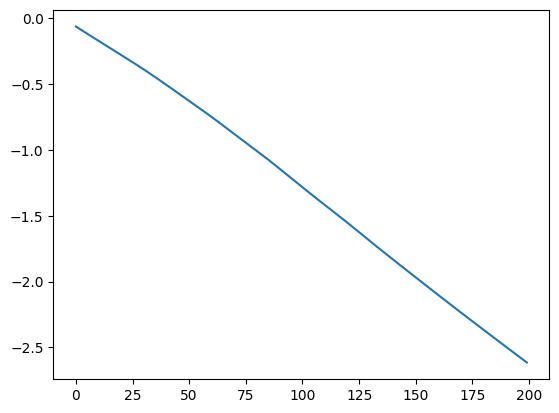

In [ ]:
plt.plot(losses)